# Inspecting data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

In [13]:
df = pd.read_json('../data/conversations.jsonl', lines=True)

## Basic Dataset Statistics

In [14]:
# Total conversations and successful fetches
print(f"Total records: {len(df)}")
print(f"Successful fetches: {df['fetch_success'].sum()}")
print(f"Failed fetches: {(~df['fetch_success']).sum()}")
print(f"Success rate: {df['fetch_success'].mean():.2%}")
print(f"\nDate range:")
print(f"  First fetch: {pd.to_datetime(df['fetched_at'], unit='s').min()}")
print(f"  Last fetch: {pd.to_datetime(df['fetched_at'], unit='s').max()}")

Total records: 6661
Successful fetches: 4512
Failed fetches: 2149
Success rate: 67.74%

Date range:
  First fetch: 2025-12-06 01:23:29
  Last fetch: 2025-12-10 08:42:09


In [15]:
# Filter to only successful fetches for clean dataset
df_clean = df[df['fetch_success']].copy()

print(f"Cleaned dataset: {len(df_clean)} successful conversations")
print(f"Removed: {len(df) - len(df_clean)} failed fetches")
print(f"\nWorking with {len(df_clean)} conversations for all subsequent analysis")

Cleaned dataset: 4512 successful conversations
Removed: 2149 failed fetches

Working with 4512 conversations for all subsequent analysis


In [16]:
# Get all unique keys from conversation_metadata
metadata_keys = set()
for idx, row in df_clean.iterrows():
    if row.get('conversation_metadata'):
        metadata_keys.update(row['conversation_metadata'].keys())

print("Keys in conversation_metadata:")
for key in sorted(metadata_keys):
    print(f"  - {key}")

# Get all unique keys from conversation_summary (if it exists)
summary_keys = set()
for idx, row in df_clean.iterrows():
    if row.get('conversation_summary'):
        summary_keys.update(row['conversation_summary'].keys())

if summary_keys:
    print("\nKeys in conversation_summary:")
    for key in sorted(summary_keys):
        print(f"  - {key}")
else:
    print("\nconversation_summary: (field does not exist or is empty)")

# Show example values for first successful conversation
first_success = df_clean.iloc[0]
print("\n" + "="*50)
print("Example conversation_metadata (first record):")
print("="*50)
if first_success.get('conversation_metadata'):
    import json
    print(json.dumps(first_success['conversation_metadata'], indent=2))

if first_success.get('conversation_summary'):
    print("\n" + "="*50)
    print("Example conversation_summary (first record):")
    print("="*50)
    print(json.dumps(first_success['conversation_summary'], indent=2))


Keys in conversation_metadata:
  - citation_count
  - code_block_count
  - code_execution_count
  - conversation_id
  - create_time
  - current_node
  - custom_gpt_used
  - file_count
  - file_types
  - gizmo_ids
  - has_custom_instructions
  - has_reasoning
  - is_archived
  - is_public
  - memory_scope
  - reasoning_message_count
  - title
  - tool_call_count
  - tools_used
  - update_time

Keys in conversation_summary:
  - assistant_messages
  - duration_seconds
  - first_message_time
  - has_system_prompt
  - last_message_time
  - message_count
  - system_messages
  - user_messages

Example conversation_metadata (first record):
{
  "title": "Songhai-model creation",
  "conversation_id": "69337716-6590-8012-b3fe-2c0a28192de6",
  "create_time": 1764980502.397475,
  "update_time": 1764980504.256415,
  "is_public": true,
  "is_archived": false,
  "current_node": "5b0ff9b4-397e-4c6e-903d-0d46b8fa616d",
  "memory_scope": "global_enabled",
  "has_custom_instructions": true,
  "custom_gpt_

## Subreddit Distribution

In [17]:
# Extract subreddits from reddit_sources
def extract_subreddits(row):
    if row['reddit_sources']:
        return [source['subreddit'] for source in row['reddit_sources']]
    return []

df_clean['subreddits'] = df_clean.apply(extract_subreddits, axis=1)

# Flatten and count
all_subreddits = [sub for subs in df_clean['subreddits'] for sub in subs]
subreddit_counts = pd.Series(all_subreddits).value_counts()

print(f"Unique subreddits: {len(subreddit_counts)}")
print(f"\nTop 25 subreddits:")
print(subreddit_counts.head(25))

Unique subreddits: 2325

Top 25 subreddits:
ChatGPT                   738
insoowon                  304
MythProofGod              119
OpenAI                     87
paletteofpotential         64
u_Choice-Ad-6834           58
politics                   51
advancedtechresearch       48
ChatGPTPro                 37
AgentTheory                35
redone_tech                33
ArtificialSentience        29
philosophy                 29
singularity                28
u_midmarket-fighter-13     26
todayilearned              26
mundodaarte                25
u_seongchun                25
technology                 25
Junk_Removal_Info          23
dicasdenomes               19
ColombianGold              19
india                      17
u_Different_Grab_5932      17
news                       17
Name: count, dtype: int64


In [18]:
# Check top Reddit users (authors) to detect potential inflation
def extract_authors(row):
    if row['reddit_sources']:
        return [source['author'] for source in row['reddit_sources']]
    return []

df_clean['authors'] = df_clean.apply(extract_authors, axis=1)

# Flatten and count
all_authors = [author for authors in df_clean['authors'] for author in authors]
author_counts = pd.Series(all_authors).value_counts()

print(f"Unique Reddit authors: {len(author_counts)}")
print(f"\nTop 10 Reddit users posting ChatGPT shares:")
print(author_counts.head(10))

# Check concentration - what % of conversations come from top users
top_10_total = author_counts.head(10).sum()
print(f"\nTop 10 users account for: {top_10_total} conversations ({top_10_total/len(all_authors)*100:.1f}% of total)")

# Check if there's significant inflation from single users
threshold = len(all_authors) * 0.05  # 5% of total
heavy_posters = author_counts[author_counts > threshold]
if len(heavy_posters) > 0:
    print(f"\n⚠️  Users posting >5% of total conversations:")
    print(heavy_posters)
else:
    print(f"\n✓ No single user dominates (no user >5% of total)")

Unique Reddit authors: 3230

Top 10 Reddit users posting ChatGPT shares:
seongchun               329
Enceing                 119
big_johnny_bee           64
Choice-Ad-6834           58
andrehp                  56
UnifiedQuantumField      54
Adventurous_Rate7118     44
paolojesus               38
redon3_tech              33
AccomplishedDuck3690     28
Name: count, dtype: int64

Top 10 users account for: 823 conversations (15.9% of total)

⚠️  Users posting >5% of total conversations:
seongchun    329
Name: count, dtype: int64


## Conversation Turn Statistics

In [19]:
# Calculate turns (user prompt -> assistant response pairs)
def count_turns(messages):
    """
    A turn is defined as a user message followed by an assistant response.
    We count the number of assistant messages as they represent completed turns.
    """
    if not messages:
        return 0
    # Count assistant messages (each represents a completed turn)
    return sum(1 for msg in messages if msg.get('role') == 'assistant')

def count_messages_by_role(messages):
    if not messages:
        return {}
    roles = {}
    for msg in messages:
        role = msg.get('role', 'unknown')
        roles[role] = roles.get(role, 0) + 1
    return roles

df_clean['turn_count'] = df_clean['messages'].apply(count_turns)
df_clean['message_count'] = df_clean['messages'].apply(lambda x: len(x) if x else 0)
df_clean['role_counts'] = df_clean['messages'].apply(count_messages_by_role)

print("Turn Statistics:")
print(f"  Mean turns per conversation: {df_clean['turn_count'].mean():.2f}")
print(f"  Median turns: {df_clean['turn_count'].median():.0f}")
print(f"  Max turns: {df_clean['turn_count'].max():.0f}")
print(f"  Min turns: {df_clean['turn_count'].min():.0f}")
print(f"\nNote: A turn = user prompt → assistant response")

print(f"\nMessage Statistics:")
print(f"  Mean messages per conversation: {df_clean['message_count'].mean():.2f}")
print(f"  Median messages: {df_clean['message_count'].median():.0f}")
print(f"  Max messages: {df_clean['message_count'].max():.0f}")
print(f"  Total messages: {df_clean['message_count'].sum():.0f}")

Turn Statistics:
  Mean turns per conversation: 16.77
  Median turns: 7
  Max turns: 823
  Min turns: 0

Note: A turn = user prompt → assistant response

Message Statistics:
  Mean messages per conversation: 34.71
  Median messages: 15
  Max messages: 1772
  Total messages: 156601


(0.0, 20.0)

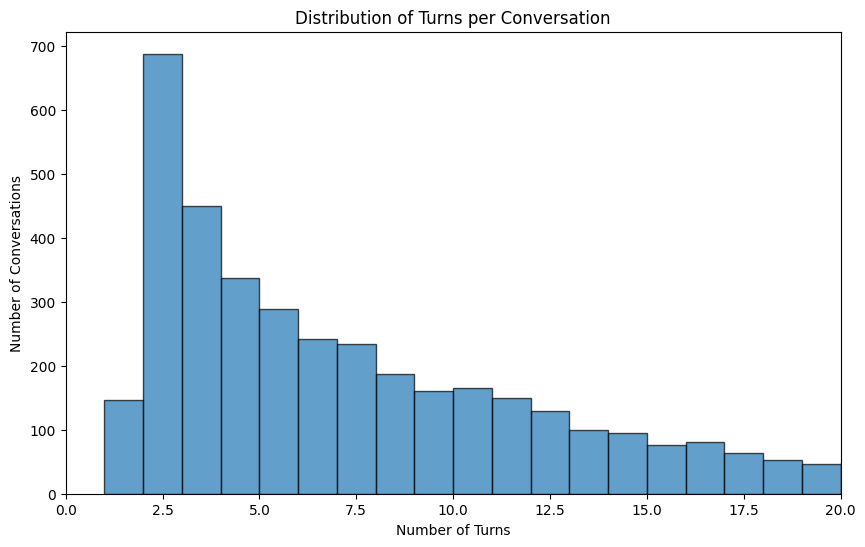

In [23]:
# show distribution of turns
plt.figure(figsize=(10, 6))
plt.hist(df_clean['turn_count'], bins=range(1, df_clean['turn_count'].max() + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Turns per Conversation')
plt.xlabel('Number of Turns')
plt.ylabel('Number of Conversations')

# scale the plot to a range of turns 0-50
plt.xlim(0, 20)

In [49]:
# Message role distribution across all conversations
all_roles = {}
for role_dict in df_clean['role_counts']:
    for role, count in role_dict.items():
        all_roles[role] = all_roles.get(role, 0) + count

print("\nMessage Role Distribution (total):")
for role, count in sorted(all_roles.items(), key=lambda x: -x[1]):
    print(f"  {role}: {count:,} ({count/sum(all_roles.values())*100:.1f}%)")


Message Role Distribution (total):
  assistant: 72,190 (48.1%)
  user: 51,462 (34.3%)
  tool: 15,301 (10.2%)
  system: 11,082 (7.4%)


## Language Detection

In [24]:
# Install langdetect if needed
try:
    from langdetect import detect, LangDetectException
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'langdetect'])
    from langdetect import detect, LangDetectException

def detect_message_language(text):
    if not text or len(text.strip()) < 10:  # Skip very short texts
        return 'unknown'
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

def detect_conversation_language(messages):
    """Detect dominant language in a conversation by combining all user+assistant text"""
    if not messages:
        return 'unknown'
    
    # Combine all user and assistant messages
    combined_text = []
    for msg in messages:
        if msg.get('role') in ['user', 'assistant'] and msg.get('text'):
            combined_text.append(msg['text'])
    
    if not combined_text:
        return 'unknown'
    
    # Combine into single text for more accurate detection
    full_text = ' '.join(combined_text)
    
    if len(full_text.strip()) < 20:
        return 'unknown'
    
    try:
        return detect(full_text)
    except LangDetectException:
        return 'unknown'

# Detect language for each conversation
print("Detecting language for each conversation...")
print("(This may take a minute...)\n")

df_clean['conversation_language'] = df_clean['messages'].apply(detect_conversation_language)

# Language distribution
lang_counts = df_clean['conversation_language'].value_counts()

print("Language Distribution (all conversations):")
for lang, count in lang_counts.items():
    print(f"  {lang}: {count:,} ({count/len(df_clean)*100:.1f}%)")

# Count English conversations
english_count = df_clean[df_clean['conversation_language'] == 'en'].shape[0]
print(f"\nEnglish conversations: {english_count:,} ({english_count/len(df_clean)*100:.1f}%)")
print(f"Non-English conversations: {len(df_clean) - english_count:,} ({(len(df_clean) - english_count)/len(df_clean)*100:.1f}%)")

Detecting language for each conversation...
(This may take a minute...)

Language Distribution (all conversations):
  en: 3,797 (84.2%)
  pt: 163 (3.6%)
  es: 148 (3.3%)
  de: 47 (1.0%)
  fr: 38 (0.8%)
  zh-cn: 34 (0.8%)
  ru: 29 (0.6%)
  tr: 29 (0.6%)
  it: 25 (0.6%)
  ar: 25 (0.6%)
  ko: 22 (0.5%)
  nl: 17 (0.4%)
  vi: 16 (0.4%)
  unknown: 15 (0.3%)
  ja: 14 (0.3%)
  pl: 14 (0.3%)
  id: 13 (0.3%)
  hr: 9 (0.2%)
  th: 7 (0.2%)
  no: 5 (0.1%)
  uk: 5 (0.1%)
  cs: 4 (0.1%)
  hu: 4 (0.1%)
  ro: 4 (0.1%)
  el: 3 (0.1%)
  ca: 3 (0.1%)
  fa: 3 (0.1%)
  he: 2 (0.0%)
  bn: 2 (0.0%)
  sv: 2 (0.0%)
  tl: 2 (0.0%)
  zh-tw: 2 (0.0%)
  et: 1 (0.0%)
  af: 1 (0.0%)
  mk: 1 (0.0%)
  so: 1 (0.0%)
  hi: 1 (0.0%)
  da: 1 (0.0%)
  sk: 1 (0.0%)
  cy: 1 (0.0%)
  lv: 1 (0.0%)

English conversations: 3,797 (84.2%)
Non-English conversations: 715 (15.8%)
Language Distribution (all conversations):
  en: 3,797 (84.2%)
  pt: 163 (3.6%)
  es: 148 (3.3%)
  de: 47 (1.0%)
  fr: 38 (0.8%)
  zh-cn: 34 (0.8%)
  ru: 29 (

In [25]:
# Create English-only dataset for subsequent analysis
df_english = df_clean[df_clean['conversation_language'] == 'en'].copy()

print(f"English-only dataset: {len(df_english)} conversations")
print(f"Filtered out: {len(df_clean) - len(df_english)} non-English conversations")

English-only dataset: 3797 conversations
Filtered out: 715 non-English conversations


In [26]:
# Recalculate turn and message counts for English dataset
df_english['turn_count'] = df_english['messages'].apply(count_turns)
df_english['message_count'] = df_english['messages'].apply(lambda x: len(x) if x else 0)
df_english['role_counts'] = df_english['messages'].apply(count_messages_by_role)

print("Turn Statistics (English only):")
print(f"  Mean turns per conversation: {df_english['turn_count'].mean():.2f}")
print(f"  Median turns: {df_english['turn_count'].median():.0f}")
print(f"  Max turns: {df_english['turn_count'].max():.0f}")
print(f"  Min turns: {df_english['turn_count'].min():.0f}")
print(f"\nNote: A turn = user prompt → assistant response")

print(f"\nMessage Statistics (English only):")
print(f"  Mean messages per conversation: {df_english['message_count'].mean():.2f}")
print(f"  Median messages: {df_english['message_count'].median():.0f}")
print(f"  Max messages: {df_english['message_count'].max():.0f}")
print(f"  Total messages: {df_english['message_count'].sum():.0f}")

# Message role distribution
all_roles_en = {}
for role_dict in df_english['role_counts']:
    for role, count in role_dict.items():
        all_roles_en[role] = all_roles_en.get(role, 0) + count

print("\nMessage Role Distribution (English only):")
for role, count in sorted(all_roles_en.items(), key=lambda x: -x[1]):
    print(f"  {role}: {count:,} ({count/sum(all_roles_en.values())*100:.1f}%)")

Turn Statistics (English only):
  Mean turns per conversation: 16.19
  Median turns: 7
  Max turns: 823
  Min turns: 0

Note: A turn = user prompt → assistant response

Message Statistics (English only):
  Mean messages per conversation: 33.43
  Median messages: 15
  Max messages: 1772
  Total messages: 126924

Message Role Distribution (English only):
  assistant: 61,455 (48.4%)
  user: 43,633 (34.4%)
  tool: 12,776 (10.1%)
  system: 9,060 (7.1%)


## Model Usage

In [27]:
# Extract model information per conversation
def get_conversation_models(row):
    """Get all unique models used in a conversation"""
    models = set()
    
    # Get conversation-level model
    if row.get('conversation_metadata'):
        conv_model = row['conversation_metadata'].get('model')
        if conv_model:
            models.add(conv_model)
    
    # Get message-level models
    if row.get('messages'):
        for msg in row['messages']:
            model_slug = msg.get('model_slug')
            if model_slug:
                models.add(model_slug)
    
    if not models:
        return 'unknown', []
    
    models_list = sorted(list(models))
    
    if len(models_list) == 1:
        return models_list[0], models_list
    else:
        return f"multi-model ({', '.join(models_list)})", models_list

df_english['model_label'], df_english['models_used'] = zip(*df_english.apply(get_conversation_models, axis=1))

model_counts = df_english['model_label'].value_counts()

print("Model Distribution (per conversation - English only):")
print(model_counts.head(20))

# Count single vs multi-model conversations
single_model = df_english[~df_english['model_label'].str.startswith('multi-model', na=False)].shape[0]
multi_model = df_english[df_english['model_label'].str.startswith('multi-model', na=False)].shape[0]

print(f"\nSingle-model conversations: {single_model:,} ({single_model/len(df_english)*100:.1f}%)")
print(f"Multi-model conversations: {multi_model:,} ({multi_model/len(df_english)*100:.1f}%)")

Model Distribution (per conversation - English only):
model_label
gpt-4o                                           2200
gpt-5                                             455
multi-model (gpt-4o, gpt-4o-mini)                 187
gpt-5-1                                           126
multi-model (gpt-5, gpt-5-thinking)                59
gpt-4o-mini                                        58
multi-model (gpt-5, gpt-5-mini)                    57
multi-model (gpt-5, gpt-5-t-mini)                  57
gpt-5-mini                                         50
multi-model (gpt-4-1-mini, gpt-4o)                 49
research                                           49
o1                                                 33
o3                                                 25
multi-model (gpt-5-1, gpt-5-t-mini)                25
o1-preview                                         24
multi-model (gpt-4o, research)                     24
gpt-5-thinking                                     21
multi-model (gpt

## Feature Usage (Tools, Files, Reasoning, etc.)

In [28]:
# Extract feature flags from conversation_metadata
def get_feature_flags(row):
    if row.get('conversation_metadata'):
        meta = row['conversation_metadata']
        return {
            'has_custom_instructions': meta.get('has_custom_instructions', False),
            'tools_used': meta.get('tools_used', []),
            'tool_call_count': meta.get('tool_call_count', 0),
            'file_count': meta.get('file_count', 0),
            'has_reasoning': meta.get('has_reasoning', False),
            'code_block_count': meta.get('code_block_count', 0),
            'code_execution_count': meta.get('code_execution_count', 0),
            'citation_count': meta.get('citation_count', 0),
            'custom_gpt_used': meta.get('custom_gpt_used', False),
            'branch_count': meta.get('branch_count', 1)
        }
    return None

df_english['features'] = df_english.apply(get_feature_flags, axis=1)
df_features = df_english[df_english['features'].notna()].copy()

print("Feature Usage Statistics (English only):")
print(f"Total conversations with metadata: {len(df_features)}\n")

# Boolean flags
print("Conversations with custom instructions:", 
      sum(f['has_custom_instructions'] for f in df_features['features']))
print("Conversations using tools:", 
      sum(len(f['tools_used']) > 0 for f in df_features['features']))
print("Conversations with reasoning traces:", 
      sum(f['has_reasoning'] for f in df_features['features']))
print("Conversations with code blocks:", 
      sum(f['code_block_count'] > 0 for f in df_features['features']))
print("Conversations with code execution:", 
      sum(f['code_execution_count'] > 0 for f in df_features['features']))
print("Conversations with citations:", 
      sum(f['citation_count'] > 0 for f in df_features['features']))
print("Conversations with custom GPT:", 
      sum(f['custom_gpt_used'] for f in df_features['features']))
print("Conversations with file attachments:", 
      sum(f['file_count'] > 0 for f in df_features['features']))
print("Conversations with branches (>1):", 
      sum(f['branch_count'] > 1 for f in df_features['features']))

# Tool usage breakdown
all_tools = []
for f in df_features['features']:
    all_tools.extend(f['tools_used'])

if all_tools:
    tool_counts = pd.Series(all_tools).value_counts()
    print(f"\nTool Usage Distribution:")
    print(tool_counts)

Feature Usage Statistics (English only):
Total conversations with metadata: 3797

Conversations with custom instructions: 3153
Conversations using tools: 1719
Conversations with reasoning traces: 393
Conversations with code blocks: 1074
Conversations with code execution: 258
Conversations with citations: 511
Conversations with custom GPT: 325
Conversations with file attachments: 340
Conversations with branches (>1): 0

Tool Usage Distribution:
web.run                                                  450
bio                                                      360
web                                                      316
python                                                   266
t2uay3k.sj1i4kz                                          189
                                                        ... 
plugin_wegpt_ai__jit_plugin.scrape_url                     1
aipdf_myaidrive_com__jit_plugin.upload_and_search_pdf      1
typeset_io__jit_plugin.vectorSearch                        1
sci

## Visualizations

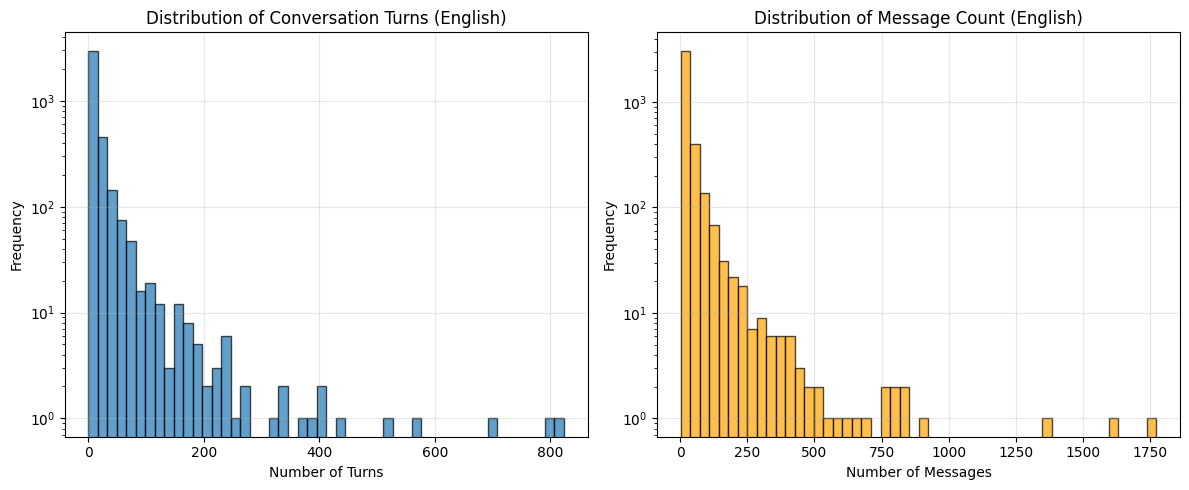

In [29]:
# Turn distribution histogram (English only)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_english['turn_count'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.title('Distribution of Conversation Turns (English)')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_english['message_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Number of Messages')
plt.ylabel('Frequency')
plt.title('Distribution of Message Count (English)')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Temporal Patterns

In [30]:
# Extract creation timestamps from conversation_metadata
def get_creation_time(row):
    if row.get('conversation_metadata'):
        return row['conversation_metadata'].get('create_time')
    return None

df_english['create_time'] = df_english.apply(get_creation_time, axis=1)
df_english['create_datetime'] = pd.to_datetime(df_english['create_time'], unit='s')

# Filter out conversations without timestamps
df_temporal = df_english[df_english['create_datetime'].notna()].copy()

print(f"Conversations with timestamps: {len(df_temporal)} ({len(df_temporal)/len(df_english)*100:.1f}%)")
print(f"\nTime range:")
print(f"  Earliest conversation: {df_temporal['create_datetime'].min()}")
print(f"  Latest conversation: {df_temporal['create_datetime'].max()}")
print(f"  Span: {(df_temporal['create_datetime'].max() - df_temporal['create_datetime'].min()).days} days")

# Conversations per month
df_temporal['year_month'] = df_temporal['create_datetime'].dt.to_period('M')
monthly_counts = df_temporal.groupby('year_month').size()

print(f"\nConversations per month (last 12 months):")
print(monthly_counts.tail(12))

Conversations with timestamps: 3797 (100.0%)

Time range:
  Earliest conversation: 2023-09-08 07:56:05.081288099
  Latest conversation: 2025-12-07 17:19:14.426053047
  Span: 821 days

Conversations per month (last 12 months):
year_month
2025-01    174
2025-02    220
2025-03    236
2025-04    290
2025-05    339
2025-06    243
2025-07    299
2025-08    315
2025-09    212
2025-10    214
2025-11    188
2025-12    195
Freq: M, dtype: int64


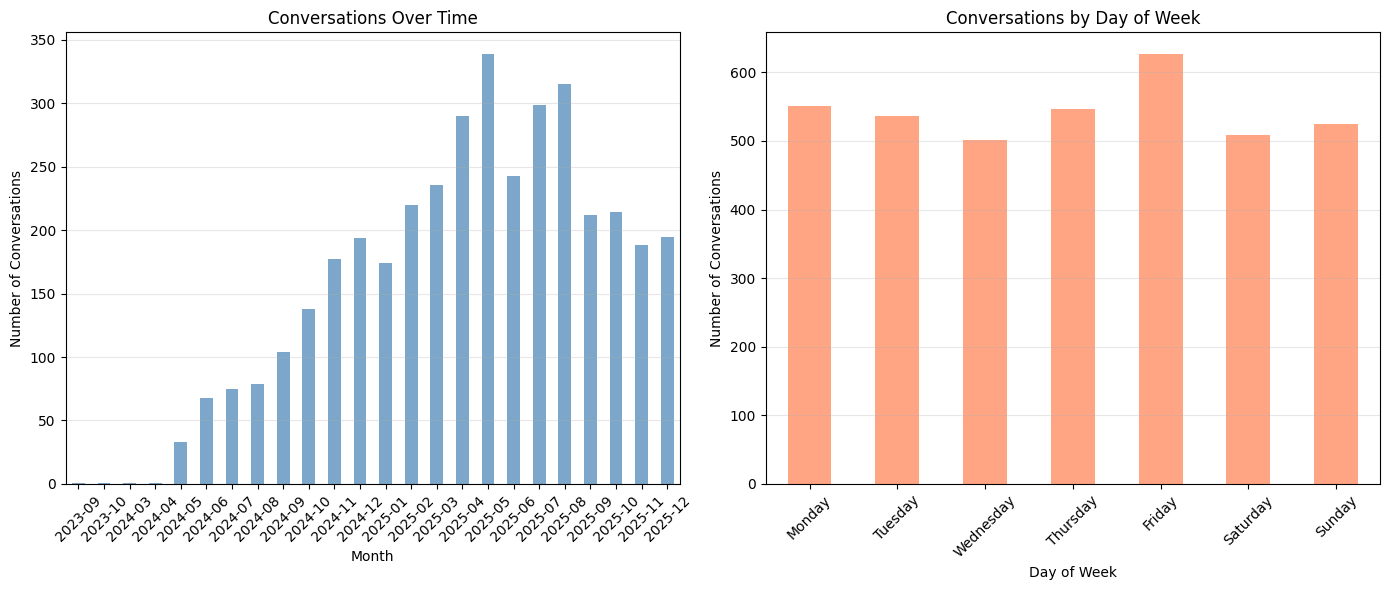

In [31]:
# Visualize temporal trends
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
monthly_counts.plot(kind='bar', color='steelblue', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Number of Conversations')
plt.title('Conversations Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
# Day of week distribution
df_temporal['day_of_week'] = df_temporal['create_datetime'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_temporal['day_of_week'].value_counts().reindex(day_order)
day_counts.plot(kind='bar', color='coral', alpha=0.7)
plt.xlabel('Day of Week')
plt.ylabel('Number of Conversations')
plt.title('Conversations by Day of Week')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [32]:
# Analyze content types in messages
def get_content_types(row):
    """Extract all unique content types from messages in a conversation"""
    content_types = []
    if row.get('messages'):
        for msg in row['messages']:
            if msg.get('content_type'):
                content_types.append(msg['content_type'])
    return content_types

df_english['all_content_types'] = df_english.apply(get_content_types, axis=1)

# Flatten and count all content types
all_types = []
for types_list in df_english['all_content_types']:
    all_types.extend(types_list)

content_type_dist = pd.Series(all_types).value_counts()
print("Content Type Distribution:")
print(content_type_dist)
print(f"\nTotal content items: {len(all_types)}")

# Check which conversations have specific content types
has_code = df_english['all_content_types'].apply(lambda x: 'code' in x).sum()
has_multimodal = df_english['all_content_types'].apply(lambda x: 'multimodal_text' in x).sum()
has_execution = df_english['all_content_types'].apply(lambda x: 'execution_output' in x).sum()

print(f"\nConversations with code: {has_code} ({has_code/len(df_english)*100:.1f}%)")
print(f"Conversations with multimodal content: {has_multimodal} ({has_multimodal/len(df_english)*100:.1f}%)")
print(f"Conversations with execution output: {has_execution} ({has_execution/len(df_english)*100:.1f}%)")

Content Type Distribution:
text                       106699
code                         6792
model_editable_context       4619
thoughts                     3458
reasoning_recap              1453
execution_output             1451
multimodal_text              1261
computer_output               380
tether_quote                  374
tether_browsing_display       296
system_error                  141
Name: count, dtype: int64

Total content items: 126924

Conversations with code: 1074 (28.3%)
Conversations with multimodal content: 356 (9.4%)
Conversations with execution output: 258 (6.8%)


In [34]:
# Analyze text length by role
def analyze_text_lengths(row):
    """Calculate average text length by role and total conversation length"""
    user_lengths = []
    assistant_lengths = []
    total_length = 0
    
    if row.get('messages'):
        for msg in row['messages']:
            role = msg.get('role', '')
            text = msg.get('text', '')
            
            if text:
                text_len = len(text)
                total_length += text_len
                
                if role == 'user':
                    user_lengths.append(text_len)
                elif role == 'assistant':
                    assistant_lengths.append(text_len)
    
    return pd.Series({
        'avg_user_msg_length': np.mean(user_lengths) if user_lengths else 0,
        'avg_assistant_msg_length': np.mean(assistant_lengths) if assistant_lengths else 0,
        'total_conversation_length': total_length
    })

df_english[['avg_user_msg_length', 'avg_assistant_msg_length', 'total_conversation_length']] = df_english.apply(analyze_text_lengths, axis=1)

print("Text Length Statistics:")
print(f"Average user message length: {df_english['avg_user_msg_length'].mean():.0f} characters")
print(f"Average assistant message length: {df_english['avg_assistant_msg_length'].mean():.0f} characters")
print(f"Average total conversation length: {df_english['total_conversation_length'].mean():.0f} characters")

print(f"\nLongest conversations (by total text length):")
print(df_english.nlargest(5, 'total_conversation_length')[['total_conversation_length', 'turn_count', 'message_count']])

Text Length Statistics:
Average user message length: 435 characters
Average assistant message length: 2763 characters
Average total conversation length: 30827 characters

Longest conversations (by total text length):
      total_conversation_length  turn_count  message_count
4111                  1401942.0         700           1362
3401                  1218605.0         276            578
2960                  1060298.0         433            889
3074                  1026522.0         174            355
811                    927175.0         211            412


## Reasoning Depth Analysis

## Code Usage Patterns

## Text Length Analysis

## Citations & Attachments Analysis

## Content Types Distribution